# Imports

In [10]:
! pip install swifter &> /dev/null
! pip install spacy &> /dev/null
! pip install textacy &> /dev/null
! pip install pdfminer &> /dev/null

In [127]:
import spacy
import pandas as pd
from tqdm.auto import tqdm 
import swifter
import numpy as np
import plotly.express as px
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import os
import re
import gensim
import string
import textacy
from collections import Counter
from nltk.util import ngrams
from matplotlib import pyplot
import seaborn as sns
pd.options.plotting.backend = "plotly"
import csv
import math
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import figure
import pdfminer

In [11]:
! python -m spacy download en_core_web_md &> /dev/null
! pip install spacytextblob &> /dev/null

In [12]:
from spacytextblob.spacytextblob import SpacyTextBlob
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [129]:
path = "/content/drive/MyDrive/Commission Adoption Feedback/Pdf/F2488672.pdf"

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

In [130]:
text = convert_pdf_to_txt(path)
text

' \n\n \n\nSAZKA Group submission to the EC public consultation on Artificial \n\nIntelligence – ethical and legal requirements  (“EC proposal on the Artificial \n\nIntelligence Act”1) \n\n \n\n1.  Short intro  \n\nSAZKA Group (SG) is one of Europe’s fastest growing lottery companies, primarily \nfocused on national lottery games, instant lotteries and online lotteries with a \nsecondary focus on digital gambling and sports betting; SG has leading market \npositions in the Czech Republic, Greece, Cyprus, Austria and Italy. As one of the \nEuropean lottery leaders, SG is acknowledged in the world lottery market for its \niconic and trusted brands and unrivalled distribution networks. Through our 63,000 \npoints of sale and digital platforms, SG serves an addressable market of over 79 \nmillion adults, bringing in annual sales of over €17bn. (https://www.sazkagroup.com/)  \n\n \n\n2.  General Comments \n\nArtificial Intelligence (AI) represents both opportunities and risks for societies,

# Data import

## Pdf to txt

Converting from pdf to txt and saving on G drive. Run only if needed

In [37]:
docs2 = []
names = []
path = "/content/drive/MyDrive/Commission Adoption Feedback/Pdf"
os.chdir(path)

for file in os.listdir():
    # Check whether file is in text format or not
     if file.endswith(".pdf"):
         file_path = f"{path}/{file}"
         names.append(file)
         #print(file_path)
         # call read text file function
         os.chdir("/content")
         text = convert_pdf_to_txt(file_path)
         #print(text_file)
         docs2.append(text)
os.chdir("/content")

In [39]:
names[:5]

['F2665651.pdf',
 'F2665650.pdf',
 'F2665649.pdf',
 'F2665648.pdf',
 'F2665647.pdf']

In [41]:
w_path = "/content/drive/MyDrive/Commission Adoption Feedback/Text/"
for i in range(len(docs2)):
  with open( w_path + names[i].replace(".pdf","") + '.txt', 'w') as f:
    f.write(docs2[i])

## Read txt

In [46]:
docs2 = []
names = []
path = "/content/drive/MyDrive/Commission Adoption Feedback/Text"
os.chdir(path)

for file in os.listdir():
    # Check whether file is in text format or not
     if file.endswith(".txt"):
         file_path = f"{path}/{file}"
         names.append(file)
         #print(file_path)
         # call read text file function
         os.chdir("/content")
         text_file = open(file_path, "r")
         #print(text_file)
         data = text_file.read()
         docs2.append(data)
os.chdir("/content")

In [49]:
docs3 = []
for x in docs2:
    docs3.append(x.replace("\n" or "\u200b", " "))

d = {"Name": names, "Text": docs3}
df = pd.DataFrame(d)
df['word_count'] = df["Text"].apply(lambda x : len(x.split()))
df['char_count'] = df['Text'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['char_count'] + 1)

df.head(5)

,Name,Text,word_count,char_count,word_density
0,F2665651.txt,T: +32 (0) 2 212 3182 F: +30 2...,2679,15393,0.174029
1,F2665650.txt,AI Austria commends the European Commi...,688,4039,0.170297
2,F2665649.txt,European Commission adoption consultation: Ar...,14500,84464,0.171669
3,F2665648.txt,CHAI Position Paper on the EU Arti cial Intell...,2783,15909,0.174921
4,F2665647.txt,REQUEST FOR COMMENT RESPONSE Proposal for a R...,1045,6697,0.156017


In [112]:
df.sort_values(by=['word_count'],ascending=False)[:5]

,Name,Text,word_count,char_count,word_density
97,F2665480.txt,how the eu can ...,36608,209272,0.174929
8,F2665642.txt,76 article international data privacy law 00...,29870,147680,0.202260
54,F2665558.txt,forthcoming in computer law security review ...,23216,135613,0.171192
60,F2665546.txt,p a g e 1 f l i p o s i t i o n p a p e ...,20092,20107,0.999204
154,F2665266.txt,disrupted ch ldhood 1 the cost of persuas...,17893,96754,0.184931


### Long texts

In [51]:
df.sort_values(by=['word_count'],ascending=True)[:20]

,Name,Text,word_count,char_count,word_density
38,F2665590.txt,Putting startups at the heart of AI innovation...,376,1938,0.193914
163,F2665222.txt,ESR Statement European Commission prop...,442,2500,0.176729
175,F2663391.txt,"Madrid, 30 de julio de 2021 La Asoci...",486,2744,0.177049
180,F2663361.txt,[Status] EIT Health AI consultation respo...,509,2842,0.179036
26,F2665614.txt,28 June 2021 AI Ac...,546,2965,0.184086
152,F2665284.txt,Response to the European Commission Consultati...,569,3242,0.175455
6,F2665645.txt,"August 6, 2021 APCIA Response to Eu...",577,3472,0.166139
208,F2662463.txt,EACA Comment on the European Commi...,606,3384,0.179025
100,F2665477.txt,Move EU's position on the European Commission ...,609,3518,0.173061
192,F2663125.txt,Amendment 1 (NEW) Proposal for a regulat...,620,3198,0.193811


### Short Texts


Maybe lets consider texts above 250 words, because shorter ones give no information

In [55]:
df = df[df["word_count"]>250]

In [56]:
en = spacy.load("en_core_web_md")
en.add_pipe('spacytextblob')

# Data Cleaning

In [52]:
def my_lower(text):
    return text.lower()

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def custom_regex(text):
    ref=re.compile(r'ref|\.')
    ares=re.compile(r'ares|\(20(?:00|1[09]|2[01])\)')
    com=re.compile(r'com\([0-9]{1,4}\)')
    bignum = re.compile(r'[0-9]{5,30}')
    parenth = re.compile(r'\([0-9]{1,4}\)')
    email = re.compile(r'(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)')
    listing = re.compile(r'\([1-3]\)|\[[1-3]\]|[1-3]\.')
    page1 = re.compile(r'Page [0-9]{1,2}(?: \/ |\/)[0-9]{1,2}}')
    page2 = re.compile(r'Page [0-9]{1,2} of [0-9]{1,2}')
    page3 = re.compile(r'[0-9]{1,2} of [0-9]{1,2}')
    marks = re.compile(r'[\u2612\uF0B7\\x2D\u2022\u2713]')
    roman = re.compile(r'x(?:v?iii|i[vx]|x)|x(?:v?ii|vi?|i)?|v(?:i(?:ii|\.)|\.)|i(?:ii?\.|v\.|[\.x])|vii')
    questionaire = re.compile(r'1\-Not important at all|5\- Very important|2\- Not important|No opinion|4Important|3Neutral')
    text = ref.sub(r'',text)
    text = ares.sub(r'',text)
    text = com.sub(r'',text)
    text = bignum.sub(r'',text)
    text = parenth.sub(r'',text)
    text = email.sub(r'',text)
    text = listing.sub(r'',text)
    text = page1.sub(r'',text)
    text = page2.sub(r'',text)
    text = page3.sub(r'',text)
    text = marks.sub(r'',text)
    text = roman.sub(r'',text)
    text = questionaire.sub(r'',text)
    return text

def clean(df,text_col='Text'):
  df[text_col]=df[text_col].apply(lambda x : my_lower(x))
  df[text_col]=df[text_col].apply(lambda x : remove_URL(x))
  df[text_col]=df[text_col].apply(lambda x : remove_html(x))
  df[text_col]=df[text_col].apply(lambda x : remove_punct(x))
  df[text_col]=df[text_col].apply(lambda x : custom_regex(x))
  return df

In [53]:
df = clean(df)

# Tokenization

To poniżej trwa stasznie długo

In [57]:
tqdm.pandas()
docs = df['Text'].swifter.apply(en)

Pandas Apply:   0%|          | 0/228 [00:00<?, ?it/s]

# Text lengths Distribution

In [113]:
doc_lens = docs.str.len()
doc_lens.hist(log_y=False)

In [120]:
doc_lens[doc_lens<2000].hist(log_y=False)

# POS - Parts of Speach analysis - nouns

In [60]:
def get_nouns(docs):
  nouns = [token.text
         for doc in docs
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "NOUN")]
  return nouns
  
def plot_counts(count_obj, names):
  fig = px.bar(count_obj,orientation='h', y=names[0], x=names[1])
  fig['layout']['yaxis']['autorange'] = "reversed"
  fig.update_layout(bargap=0.30, font={'size':10})
  return fig

def count_texts(texts,colnames=['obj', 'count'],n_obs=30):
  obj_freq = Counter(texts)
  common_obj = obj_freq.most_common(n_obs)
  count_obj = pd.DataFrame(common_obj, columns=colnames)
  return count_obj

In [61]:
nouns = get_nouns(docs)
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(30)

In [62]:
count_nouns = pd.DataFrame(common_nouns, columns=['noun', 'count'])
plot_counts(count_nouns, ['noun', 'count'])

# Word Cloud

In [63]:
def lemmatized_word_cloud(docs):
  lemmas = docs.apply(lambda doc: [token.lemma_ for token in doc if not token.is_stop if not token.is_punct if token.is_alpha])
  word_counts = Counter(lemmas.sum())
  wc = WordCloud(width=1600, height=800)
  wc.generate_from_frequencies(frequencies=word_counts)
  plt.figure(figsize=(18,14))
  plt.imshow(wc)
  return word_counts

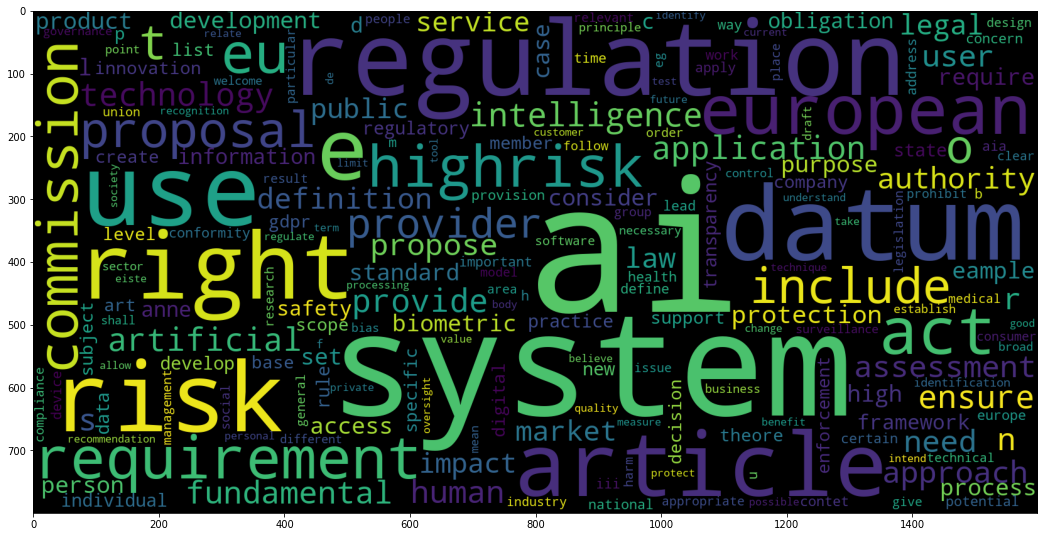

In [64]:
word_counts = lemmatized_word_cloud(docs)

In [65]:
counts = pd.DataFrame(word_counts.most_common(30), columns=['word', 'count'])
plot_counts(counts, ['word', 'count'])

# Named Entities

In [66]:
def get_entities(docs):
  entities = [(ent.text, ent.label_)
         for doc in docs
          for ent in doc.ents]
  return entities

def unique(list1):
  unique_list = []
  for x in list1:
    if x not in unique_list:
      unique_list.append(x)
  return unique_list

def organisation_like_entitites(docs, uniq=False):
  entities = get_entities(docs)
  if uniq:
    entities = unique(entities)
  entities_df = pd.DataFrame(entities, columns =['entity','type'])
  ls = ["EVENT","GPE","LAW","NORP","PERSON","ORG"]
  proper_ets = entities_df[entities_df['type'].isin(ls)]
  return proper_ets

In [67]:
proper_ets = organisation_like_entitites(docs)
proper_ets

,entity,type
3,equineteuropeorg,ORG
4,european,NORP
5,european,NORP
6,european union,ORG
8,eu,GPE
...,...,...
23106,ec,ORG
23107,sg,ORG
23108,sg,ORG
23115,kamil ziegler,PERSON


In [68]:
count_ent = proper_ets.value_counts()
count_ent = count_ent.reset_index()
count_ent.columns =["entity","type","count"]

In [69]:
plot_counts(count_ent[:20],["entity","count"])

# TF-IDF

In [70]:
def dummy_fun(doc):
    return doc

def tfidf_table(texts_df,en,top=10):
  stopwords = en.Defaults.stop_words
  vectorizer = TfidfVectorizer(stop_words=stopwords, use_idf=True, norm=None)
  #vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,token_pattern=None) 
  transformed_documents = vectorizer.fit_transform(texts_df)
  #transformed_documents = vectorizer.fit_transform(docs)
  transformed_documents_as_array = transformed_documents.toarray()
  output_filenames = [range(len(transformed_documents_as_array))]
  docs_as_dfs = []
  for counter, doc in enumerate(transformed_documents_as_array):
      tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
      one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
      docs_as_dfs.append(one_doc_as_df)
  top_tfidf = docs_as_dfs[0][:top]
  for i in range(len(docs_as_dfs)-1):
    top_tfidf = pd.concat([top_tfidf, docs_as_dfs[i+1][:10]], axis=1)

  tfidf_names = []
  for i in range(len(docs_as_dfs)):
    tfidf_names.append("term_"+str(i))
    tfidf_names.append("score_"+str(i))
  top_tfidf.columns = tfidf_names
  return top_tfidf

def counts_tfidf(top_tfidf):
  terms_tfidf = top_tfidf.loc[:, ::2]
  terms_list = []
  for i in range(len(terms_tfidf.columns)):
    for j in range(len(terms_tfidf)):
      terms_list.append(terms_tfidf.iloc[j,i])
  terms_freq = Counter(terms_list)
  common_terms = terms_freq.most_common(40)
  count_terms = pd.DataFrame(common_terms, columns=['term', 'count'])
  return count_terms

In [73]:
stopwords = en.Defaults.stop_words
vectorizer = TfidfVectorizer(stop_words=stopwords, use_idf=True, norm=None)
#vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,token_pattern=None) 
transformed_documents = vectorizer.fit_transform(df['Text'])
#transformed_documents = vectorizer.fit_transform(docs)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



In [74]:
transformed_documents_as_array = transformed_documents.toarray()

In [75]:
output_filenames = [range(len(transformed_documents_as_array))]
docs_as_dfs = []
for counter, doc in enumerate(transformed_documents_as_array):
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    docs_as_dfs.append(one_doc_as_df)

In [76]:
top_tfidf = docs_as_dfs[0][:10]
for i in range(len(docs_as_dfs)-1):
  top_tfidf = pd.concat([top_tfidf, docs_as_dfs[i+1][:10]], axis=1)

tfidf_names = []
for i in range(len(docs_as_dfs)):
  tfidf_names.append("term_"+str(i))
  tfidf_names.append("score_"+str(i))
top_tfidf.columns = tfidf_names
top_tfidf

,term_0,score_0,term_1,score_1,term_2,score_2,term_3,score_3,term_4,score_4,...,term_223,score_223,term_224,score_224,term_225,score_225,term_226,score_226,term_227,score_227
0,equality,186.091050,artificial,14.566708,ai,227.967076,classi,63.146323,crowdstrike,132.033221,...,ai,69.909903,workers,92.272483,standardization,108.307716,ai,65.857155,sg,86.108622
1,equinet,86.108622,ai,14.184618,aia,217.353869,systems,61.634366,falcon,34.443449,...,systems,37.607410,ai,66.870342,din,65.616559,aniti,45.924599,gambling,80.758842
2,ai,73.962651,intelligence,13.759767,edri,188.147080,cation,60.345513,cybersecurity,32.778401,...,smaller,31.980976,bargaining,51.061588,dke,53.351097,regulation,36.794734,sazka,40.184024
3,rights,50.871371,act,13.287729,biometric,152.914406,article,53.700079,aiml,21.771402,...,smallscale,25.203561,employees,41.172638,esos,37.946647,systems,27.160907,betting,26.675549
4,national,41.463495,data,11.796728,rights,140.206462,nition,50.474276,threats,17.444169,...,regulation,22.485671,collective,37.218210,standards,36.014101,intelligence,24.344203,czech,25.237138
5,equineteuropeorg,40.184024,circumvention,9.283925,systems,132.670585,ai,38.501106,artiﬁcial,15.178659,...,highrisk,22.348306,systems,34.473459,european,33.428809,artificial,23.530837,republic,24.121420
6,3030,40.184024,believe,8.487618,mass,131.808693,de,30.852627,inc,13.925888,...,tion,21.966800,workplace,30.502796,aia,32.309359,castetsrenard,22.962299,lottery,22.962299
7,infoequineteuropeorg,40.184024,systems,8.357202,rbi,118.621928,ned,26.675549,threat,12.917872,...,providers,16.720958,unions,27.503918,vde,28.702874,bengio,22.962299,evropská,22.962299
8,bodies,39.245686,effect,6.471168,fundamental,115.760477,clarify,26.672040,platform,12.812605,...,legislators,16.074231,regulation,26.573975,german,27.913657,notified,20.334013,vokovice,22.962299
9,318,37.345768,mass,6.429692,article,103.470884,system,25.885449,offers,11.871944,...,smes,15.397308,art,24.301860,specifications,25.196460,chairs,20.189711,praha,22.962299


In [77]:
top_tfidf = tfidf_table(df['Text'],en,top=10)
count_terms = counts_tfidf(top_tfidf)
plot_counts(count_terms, ['term', 'count'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



In [78]:
count_terms[:20]

,term,count
0,ai,203
1,systems,94
2,data,59
3,system,44
4,article,43
5,regulation,41
6,act,33
7,highrisk,22
8,aia,21
9,european,20


# Ngrams

## 2-grams

In [79]:
def get_top_ngram(corpus, n=None, m=None):
    vec = CountVectorizer(stop_words = stopwords, ngram_range=(n, m)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:30]
    
def plot_ngram(top_n_bigrams):
  x,y=map(list,zip(*top_n_bigrams))
  fig= pyplot.subplots(figsize=(15,15))
  sns.barplot(x=y,y=x)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



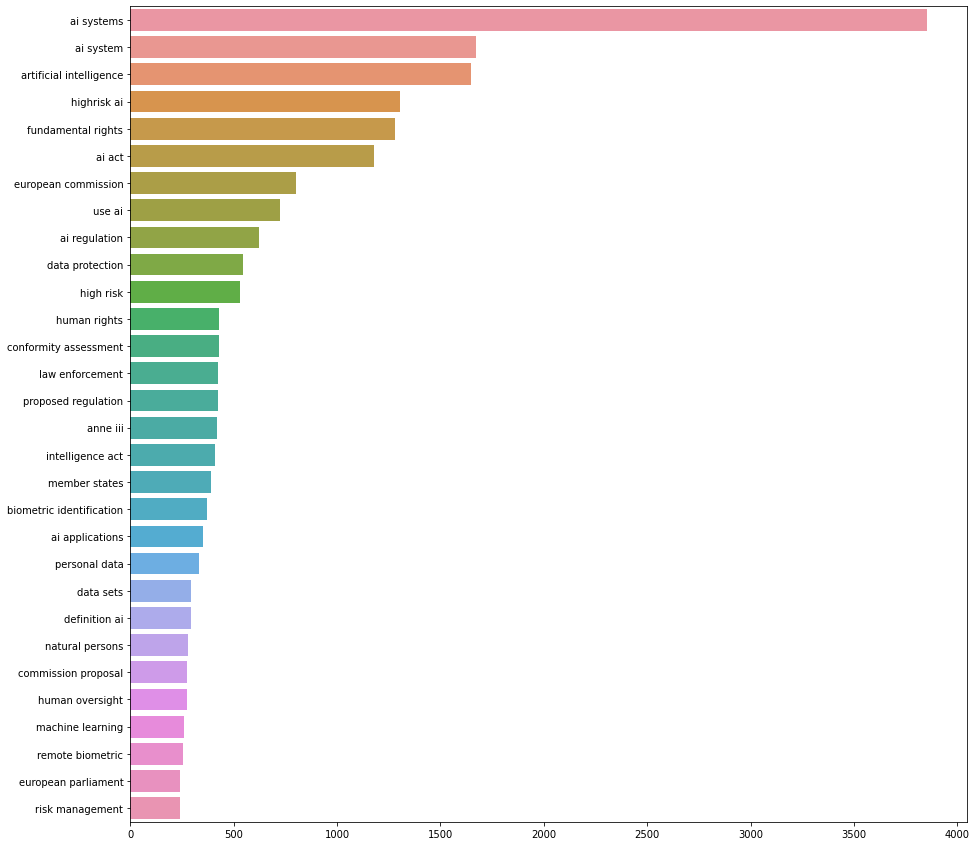

In [80]:
top_n_bigrams=get_top_ngram(df['Text'],2,2)[:30]
plot_ngram(top_n_bigrams)

## 3-grams

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



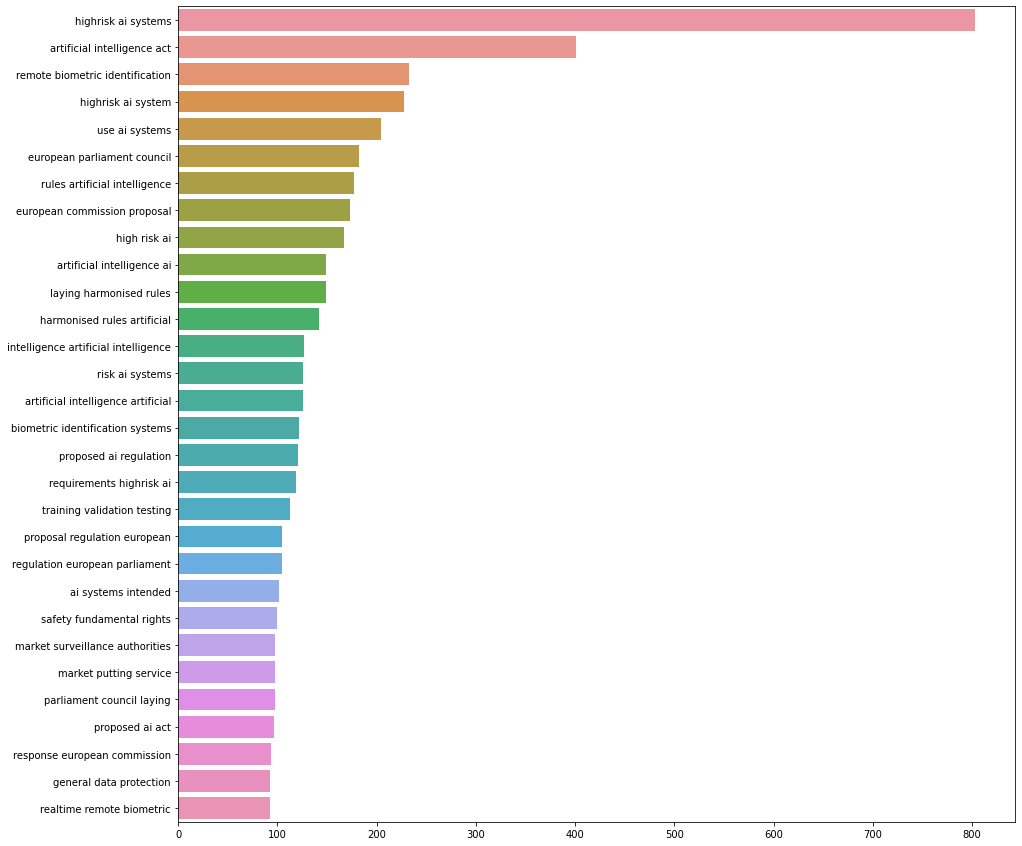

In [81]:
top_n_bigrams=get_top_ngram(df['Text'],3,3)[:30]
plot_ngram(top_n_bigrams)

## 4-grams

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



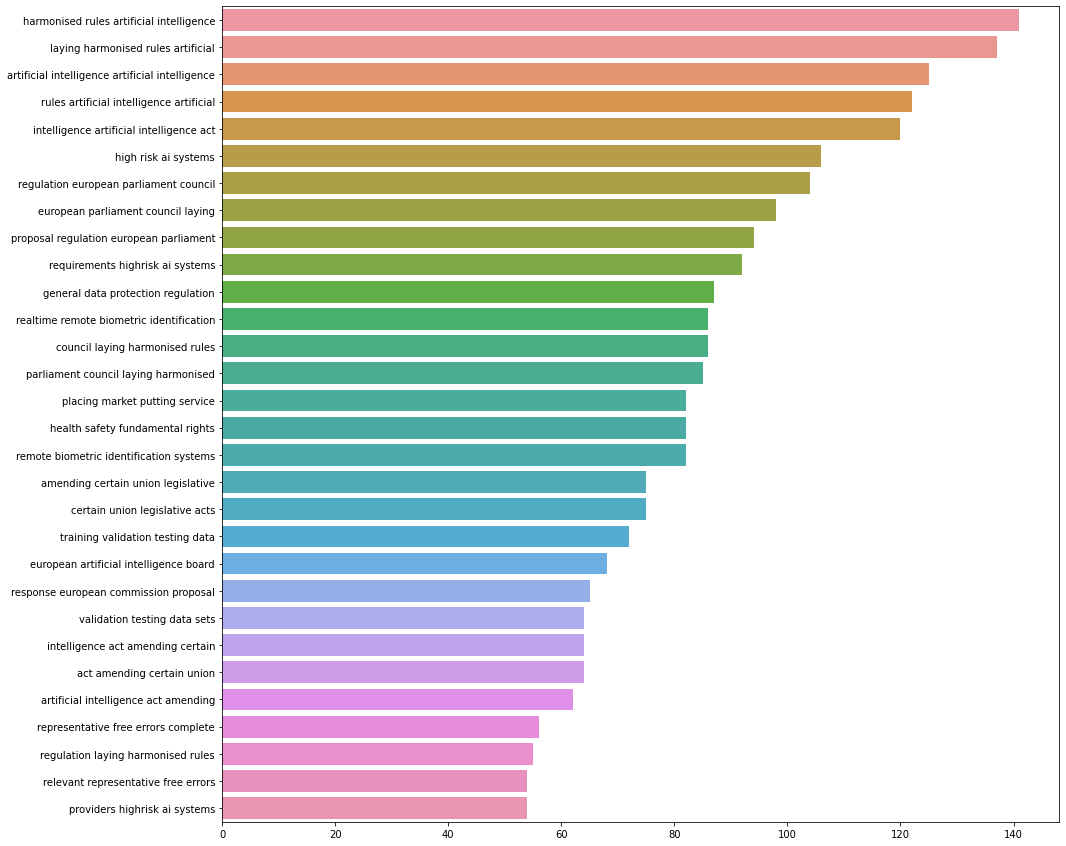

In [82]:
top_n_bigrams=get_top_ngram(df['Text'],4,4)[:30]
plot_ngram(top_n_bigrams)

## 2-5 grams

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



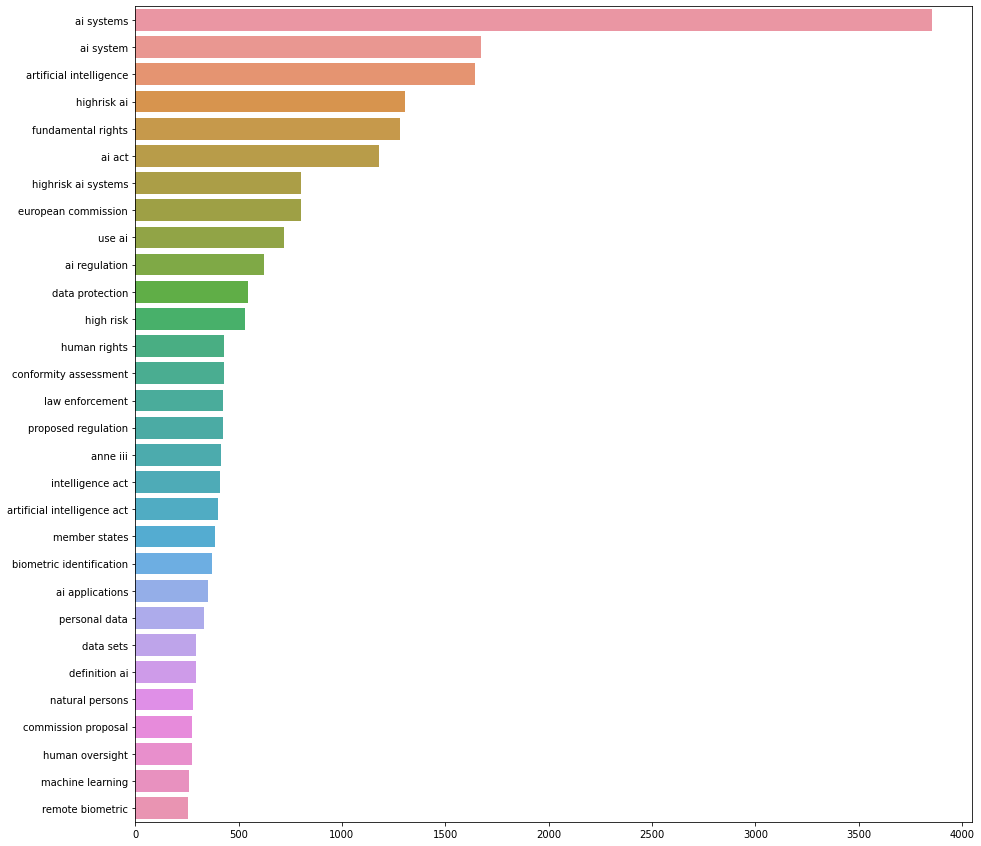

In [83]:
top_n_bigrams=get_top_ngram(df['Text'],2,5)[:30]
plot_ngram(top_n_bigrams)

# Noun Chunks

Proposition for n-gram like structure from spacy creators. It focuses on ngrams focused on nouns.

In [84]:
def get_noun_chunks(docs):
  noun_chunks = []
  for doc in docs:
    for chunk in doc.noun_chunks:
      noun_chunks.append(chunk.text)
  return noun_chunks

In [85]:
noun_chunks = get_noun_chunks(docs)

## At least two words

In [86]:
lim_noun_chunks = list(filter(lambda x: len(x.split()) > 1, noun_chunks))
count_chunks = count_texts(lim_noun_chunks,['chunk', 'count'])
plot_counts(count_chunks,['chunk', 'count'])

## At least three words

In [87]:
noun_chunks = list(filter(lambda x: len(x.split()) > 2, noun_chunks))

chunk_freq = Counter(noun_chunks)
common_chunks = chunk_freq.most_common(20)

count_chunks = pd.DataFrame(common_chunks, columns=['chunk', 'count'])

fig = px.bar(count_chunks,orientation='h', y='chunk', x='count')

fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_layout(bargap=0.30, font={'size':10})
fig

## More complex analysis

In [88]:
noun_chunks = list(filter(lambda x: len(x.split()) > 1, noun_chunks))
count_chunks = count_texts(noun_chunks,['chunk', 'count'],40)
plot_counts(count_chunks,['chunk', 'count'])

In [89]:
def get_chunks(docs):
  chunks = list()
  for doc in docs:
    chunks = chunks + list(doc.noun_chunks)
  return chunks

def top_chunk_parents(chunks,count_chunks,n_chunks=10,n_parents=5):
  chunk_parents = []
  for chunk in chunks:
    if chunk.text in (list(count_chunks["chunk"][:n_chunks])):
      chunk_parents.append((chunk.text,chunk.root.head.text))
  ch_p_df = pd.DataFrame(chunk_parents, columns =['chunk','parent'])
  count_ch_p = ch_p_df.value_counts()
  count_ch_p = count_ch_p.reset_index()
  count_ch_p.columns =["chunk","parent","count"]
  most_common_parents = []
  for el in list(count_chunks["chunk"][:n_chunks]):
    p = count_ch_p[count_ch_p["chunk"]== el][:n_parents]
    most_common_parents.append(p)
  return most_common_parents

def count_texts(texts,colnames=['obj', 'count'],n_obs=30):
  obj_freq = Counter(texts)
  common_obj = obj_freq.most_common(n_obs)
  count_obj = pd.DataFrame(common_obj, columns=colnames)
  return count_obj

In [90]:
chunks = get_chunks(docs)

In [91]:
most_common_parents = top_chunk_parents(chunks,count_chunks)

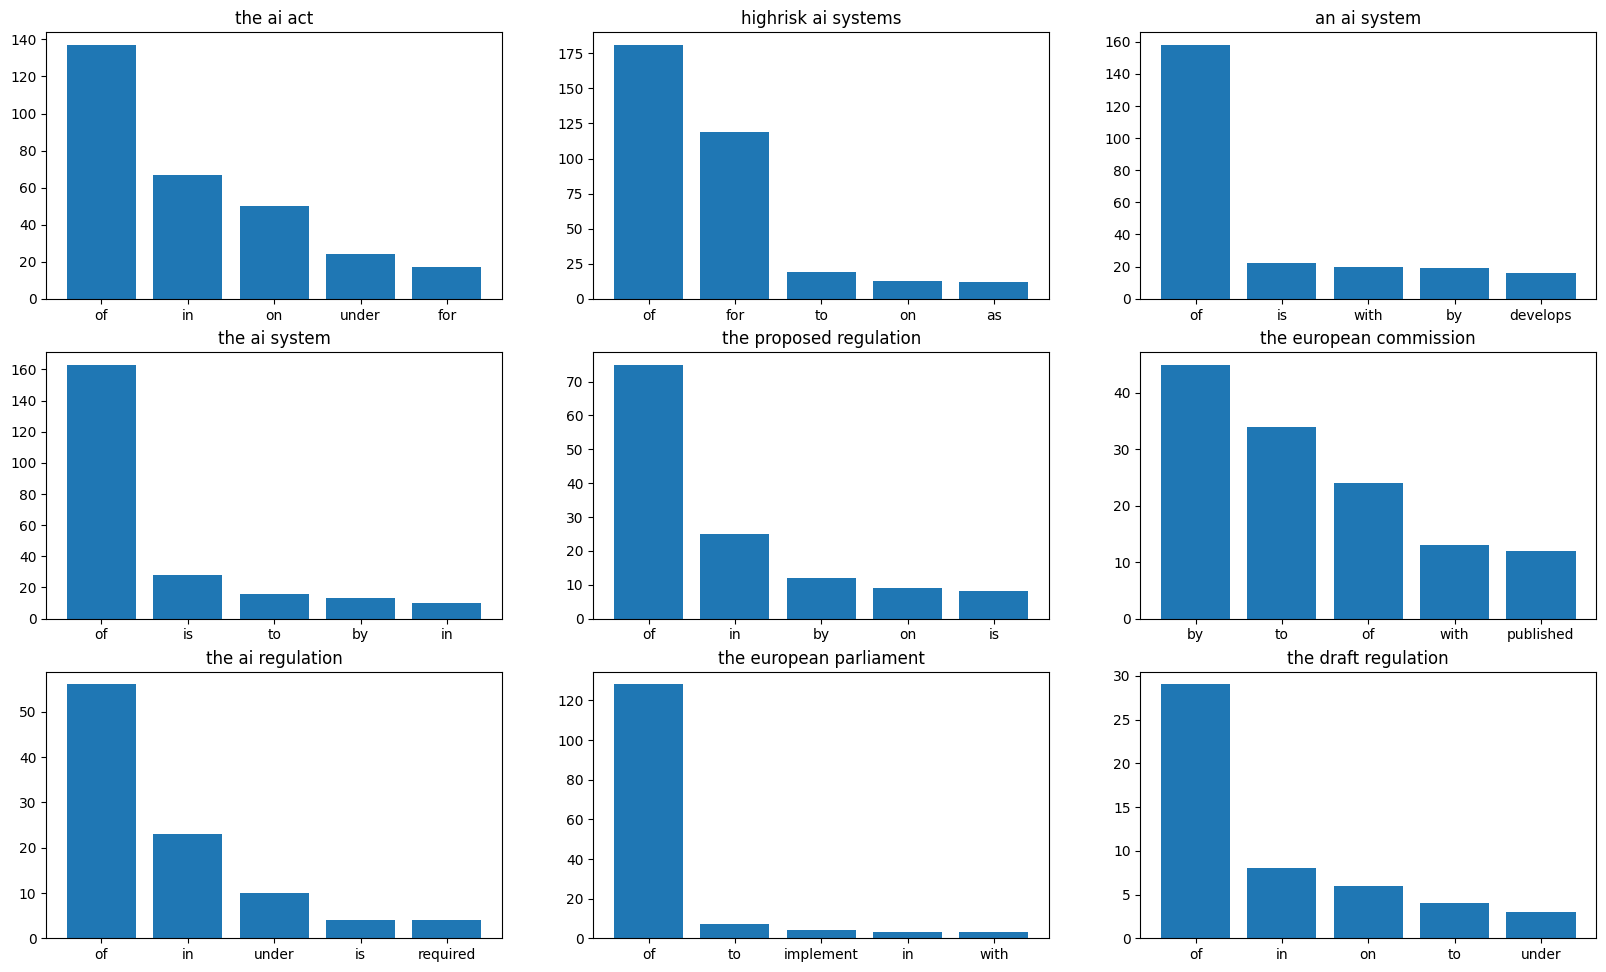

In [92]:
figure(figsize=(20, 12), dpi=100)
plt.figure(1)
for i in range(9):
  plt.subplot(331+i)
  plt.bar(most_common_parents[i]["parent"], most_common_parents[i]["count"])
  plt.title(most_common_parents[i]["chunk"].iloc[0])

## Chunk Frequency

In [93]:
freq_chunk = []
for doc in docs:
  n_chunks = []
  for chunk in doc.noun_chunks:
    n_chunks.append(chunk.text)
  freq_chunk.append(n_chunks)

In [94]:
noun_chunks = get_noun_chunks(docs)
noun_chunks = list(filter(lambda x: len(x.split()) > 1, noun_chunks))
count_chunks = count_texts(noun_chunks,['chunk', 'count'],10)
common_chunks = count_chunks['chunk']
count_chunks = count_chunks['count']
common_chunks[0]


'ai systems'

In [95]:
count_chunk = []
for ch in common_chunks:
  print(ch)
  x=0
  for i in range(len(freq_chunk)):
    if ch in freq_chunk[i]:
      x+=1
  count_chunk.append(x)
count_chunk[:3]

ai systems
the proposal
the use
the ai act
the commission
fundamental rights
the regulation
artificial intelligence
the eu
highrisk ai systems


[176, 150, 171]

In [96]:
ch_name = []
ch_count = []
for ch in common_chunks:
  ch_name.append(ch)
for ch in count_chunks:
  ch_count.append(ch)
ch_name[:5]
ch_count[:5]

[1386, 842, 822, 616, 612]

In [97]:
chunk_count_df = pd.DataFrame(ch_name)
chunk_count_df["Count"] = ch_count
chunk_count_df["CF"] = count_chunk
chunk_count_df["Percent"] = [x / len(docs) for x in count_chunk]
chunk_count_df.columns = ["Chunk","Count","ChunkFrequency", "Percent"]
chunk_count_df[:10]

,Chunk,Count,ChunkFrequency,Percent
0,ai systems,1386,176,0.771930
1,the proposal,842,150,0.657895
2,the use,822,171,0.750000
3,the ai act,616,84,0.368421
4,the commission,612,134,0.587719
5,fundamental rights,578,119,0.521930
6,the regulation,565,130,0.570175
7,artificial intelligence,476,151,0.662281
8,the eu,449,134,0.587719
9,highrisk ai systems,429,124,0.543860


In [98]:
list(chunk_count_df["Chunk"])[:5]

['ai systems', 'the proposal', 'the use', 'the ai act', 'the commission']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:

Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.



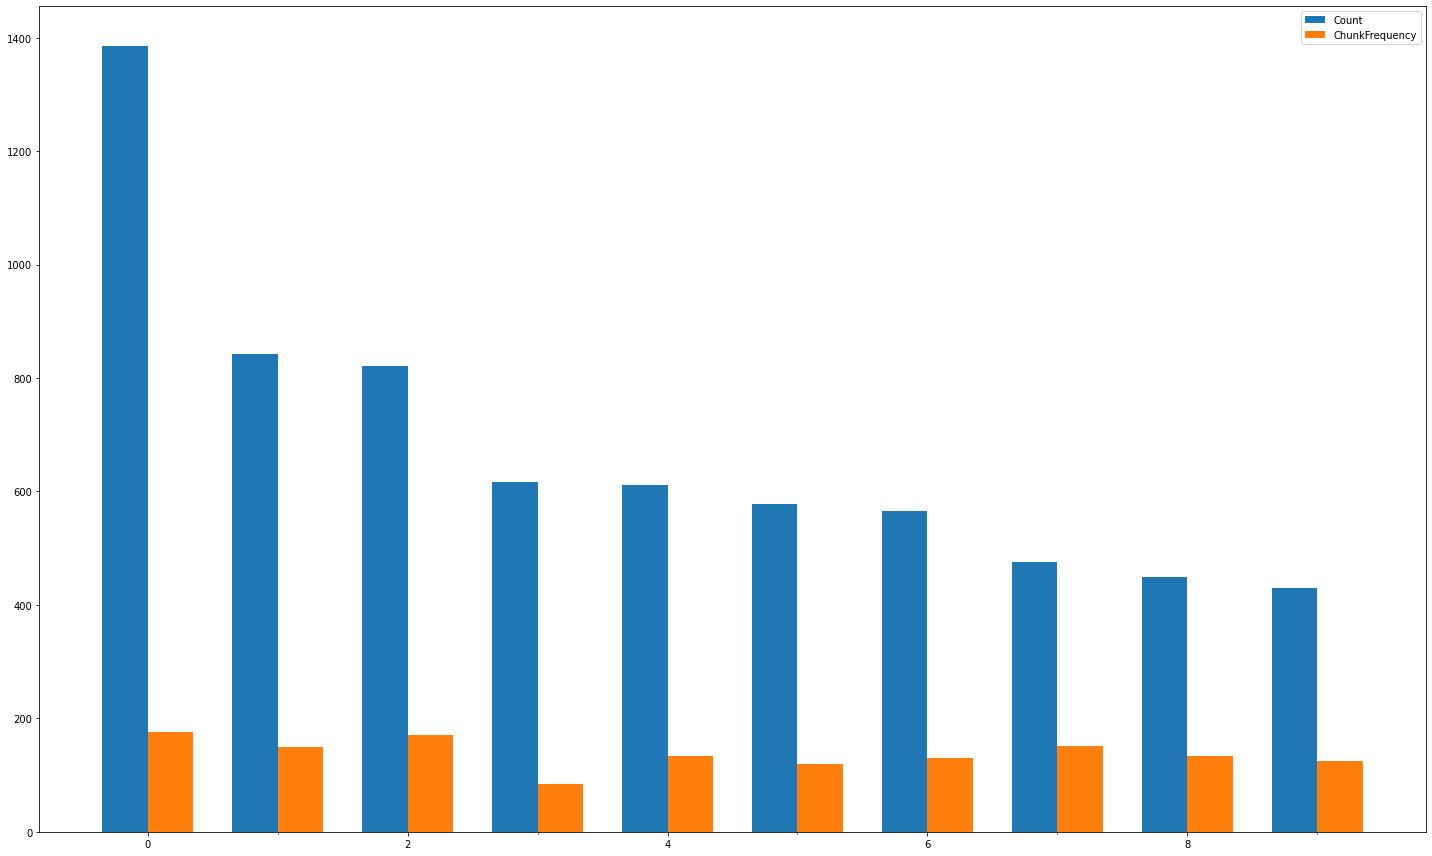

In [99]:
labels = list(chunk_count_df["Chunk"])

x = np.arange(len(chunk_count_df["Chunk"]))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(20, 12))
rects1 = ax.bar(x - width/2, chunk_count_df["Count"], width, label='Count')
rects2 = ax.bar(x + width/2, chunk_count_df["ChunkFrequency"], width, label='ChunkFrequency')

ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

# Textrank

In [100]:
keyterms = []
for doc in docs:
  keyterms.append(textacy.extract.keyterms.textrank(doc))
len(keyterms)

228

In [101]:
keyterms_list = []
for i in range(len(docs)):
  keyterms_df = pd.DataFrame.from_dict(keyterms[i])
  for j in range(len(keyterms_df[0])):
    keyterms_list.append(keyterms_df[0][j])
#keyterms_list[:5]
keyterms_freq = Counter(keyterms_list)
common_keyterms = keyterms_freq.most_common(40)
count_keyterms = pd.DataFrame(common_keyterms, columns=['keyterm', 'count'])
fig = px.bar(count_keyterms,orientation='h', y='keyterm', x='count')

fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_layout(bargap=0.30, font={'size':10})
fig

In [126]:
keyterms_df[0]

0    directive fin tech legislation nis ecommerce p...
1                           european lottery leader sg
2                national lottery game instant lottery
3                                     sport betting sg
4                                       sazka group sg
5                                  digital platform sg
6                                future development sg
7                storage datum transfer product safety
8                                     gambling product
9                        minimum age legal requirement
Name: 0, dtype: object

# Sentiment Score

In [103]:
sentiment_info = []
for doc in docs:
  sentiment = (doc._.blob.polarity, doc._.blob.subjectivity)
  sentiment_info.append(sentiment)

In [104]:
sentiment_df = pd.DataFrame.from_dict(sentiment_info)
sentiment_df.columns=["polarity","subjectivity"]
sentiment_df

,polarity,subjectivity
0,0.100353,0.428305
1,0.004525,0.511691
2,0.030567,0.437807
3,0.081266,0.403026
4,0.110041,0.418780
...,...,...
223,0.121876,0.516187
224,0.066670,0.498953
225,0.009519,0.356599
226,0.035011,0.441655


<BarContainer object of 228 artists>

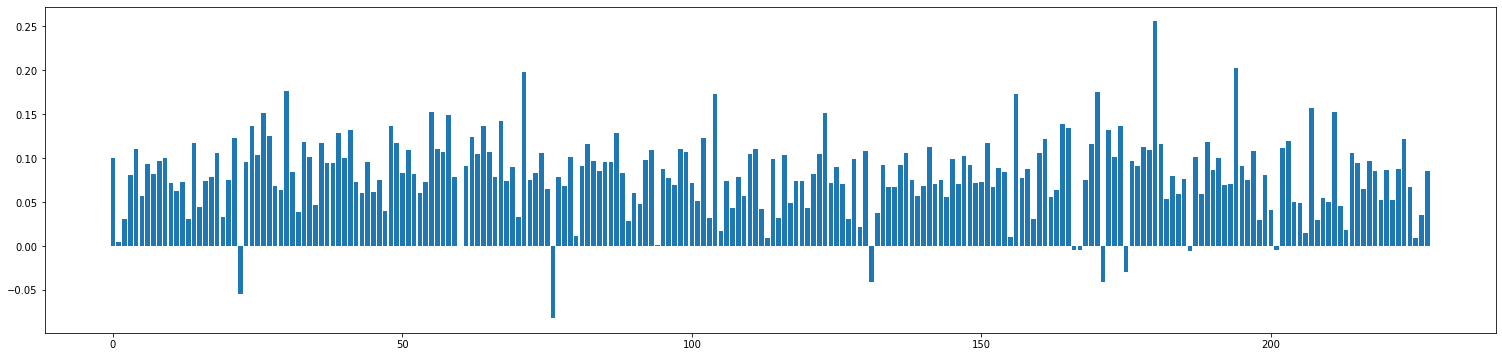

In [106]:
plt.figure(figsize=(26,6))
plt.bar(range(len(sentiment_df)), sentiment_df['polarity'])

In [110]:
sentiment_df[sentiment_df['polarity']<0]

,polarity,subjectivity
22,-0.055289,0.543616
76,-0.082047,0.600250
131,-0.041065,0.547169
166,-0.004180,0.382450
167,-0.004307,0.457285
171,-0.040658,0.440007
175,-0.029820,0.562098
186,-0.006312,0.566554
201,-0.004180,0.382450


Przejrzeć

In [108]:
df.iloc[5]["Name"]

'F2665646.txt'

<BarContainer object of 228 artists>

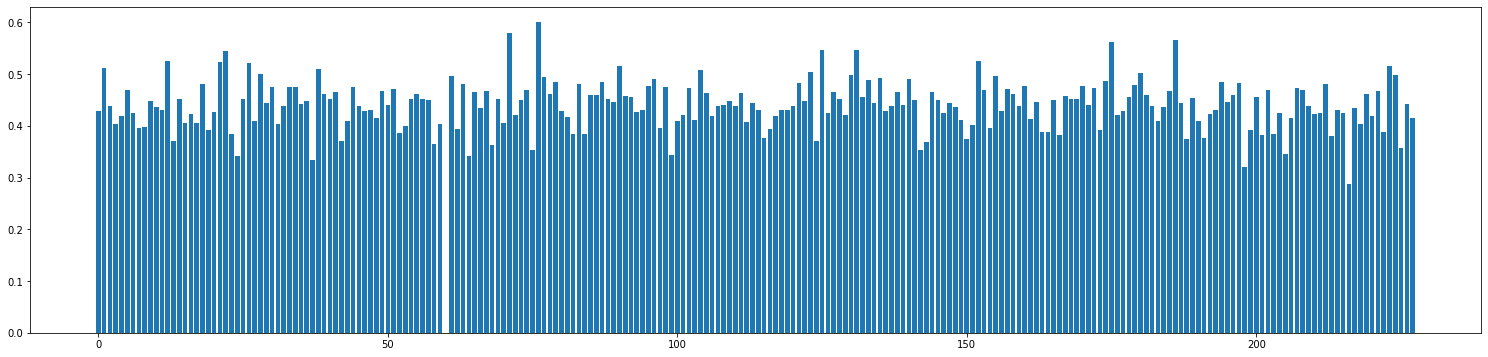

In [111]:
plt.figure(figsize=(26,6))
plt.bar(range(len(sentiment_df)), sentiment_df['subjectivity'])

As we can see from the first plot, the sentiment of the respondents answers is quiet neutral with almost only, small positive values.

Their texts are also in between in being objective or subjective.